# Intraday Resistance Breakout

1. Resistance breakout is a technical trading term which means that the price of the stock has breached a presumed resistance level (determined by price chart)
1. Choose high volume, high activity stocks for this strategy (pre-market movers, historically high volume stocks, like Tech etc.)
1. Define breakout rule - I will be using price breaching 20 period rolling max/min price in conjunction volume breaching rolling max volume - go long short stocks based on the signals.
1. Define exit/stop loss signal - I will be using previous price plus/minus 20 period ATR as the rolling stop loss price.
1. Backtest the strategy by calculating cumulative returns for each stock.

In [1]:
import numpy as np
import os
import pandas as pd
import time
from alpha_vantage.timeseries import TimeSeries

from ResistanceBreakout import ResistanceBreakout

In [2]:
os.chdir('./../3_TechnicalIndicators/')
from TechnicalIndicators import TechnicalIndicators

In [3]:
os.chdir('./../4_PerformanceMeasurement/')
from PerformanceMeasurements import PerformanceMeasurements

In [4]:
os.chdir('./../')
from Resources.APIKeys import APIKeys

In [5]:
ohlc_intraday = {}
api_call_count = 1
ts = TimeSeries(key=APIKeys.alpha_vantage, output_format='pandas')
start_time = time.time()
tickers = ['MSFT','AAPL','FB','AMZN','INTC', 'CSCO','VZ','IBM','TSLA','AMD']
# tickers = ['MSFT']

In [6]:
for ticker in tickers:
    data = ts.get_intraday(symbol=ticker, interval='5min', outputsize='full')[0]
    api_call_count += 1
    data.columns = ['Open', 'High', 'Low', 'Close', 'Volume']
    data = data[::-1]
    data = data.between_time('09:35', '16:00') # Some priviledged folks are allowed to trade outside trading hours
    ohlc_intraday[ticker] = data
    if api_call_count == 5:
        api_call_count = 1
        time.sleep(60 - ((time.time() - start_time) % 60.0))
tickers = ohlc_intraday.keys()

In [7]:
for ticker in tickers:
    ohlc = ohlc_intraday[ticker]
    TechnicalIndicators.add_atr(ohlc, 20, 'Close')
    ohlc['roll_max_cp'] = ohlc['High'].rolling(20).max()
    ohlc['roll_min_cp'] = ohlc['Low'].rolling(20).min()
    ohlc['roll_max_vol'] = ohlc['Volume'].rolling(20).max()
    ohlc.dropna(inplace=True)

In [8]:
ResistanceBreakout.calculate_returns(ohlc_intraday)

/home/somesh/notebooks/Git/AlgorithmicTradingCourse/5_BackTesting/ResistanceBreakout.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ohlc['ret'] = np.array(tickers_return[ticker])


In [9]:
strategy_df = pd.DataFrame()
for ticker in tickers:
    strategy_df[ticker] = ohlc_intraday[ticker]['ret']
strategy_df['ret'] = strategy_df.mean(axis = 1)
print(PerformanceMeasurements.get_cagr_for_returns(strategy_df['ret'].values, 252*78))
print(PerformanceMeasurements.get_sharpe_ratio_for_returns(strategy_df['ret'].values, 252*78, 0.025))
print(PerformanceMeasurements.get_max_drawdown_for_returns(strategy_df['ret'].values))

nan
nan
nan


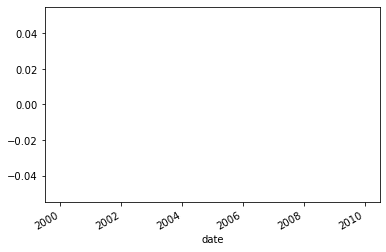

In [10]:
(1+strategy_df['ret']).cumprod().plot();

In [11]:
cagr = {}
sharpe_ratios = {}
max_drawdowns = {}
for ticker in tickers:
    cagr[ticker] = PerformanceMeasurements.get_cagr_for_returns(strategy_df['ret'].values, 252*78)
    sharpe_ratios[ticker] = PerformanceMeasurements.get_sharpe_ratio_for_returns(strategy_df['ret'].values, 252*78, 0.025)
    max_drawdowns[ticker] = PerformanceMeasurements.get_max_drawdown_for_returns(strategy_df['ret'].values)

In [12]:
KPI_df = pd.DataFrame([cagr, sharpe_ratios, max_drawdowns], index=['Return', 'Sharpe Ratio', 'Max Drawdowns'])
KPI_df.T

,Return,Sharpe Ratio,Max Drawdowns
MSFT,NaN,NaN,NaN
AAPL,NaN,NaN,NaN
FB,NaN,NaN,NaN
AMZN,NaN,NaN,NaN
INTC,NaN,NaN,NaN
CSCO,NaN,NaN,NaN
VZ,NaN,NaN,NaN
IBM,NaN,NaN,NaN
TSLA,NaN,NaN,NaN
AMD,NaN,NaN,NaN
